In [1]:
import numpy as np
import matplotlib.pylab as plt

from lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary

# Extrusion dictionary

In [2]:
paramdict = {
    'CTCF_facestall': [1.0],
    'CTCF_backstall': [0.0],
    'CTCF_lifetime': [10.],
    'CTCF_offtime': [0.1],
    'LEF_lifetime': [50],
    'LEF_stalled_lifetime': [50],
    'LEF_birth': [0.1],
    'LEF_pause': [0],
    'LEF_separation': 10,
    'sites_per_monomer': 10,
    'monomers_per_replica': 100,
    'number_of_replica': 10,
    'steps': 200,
    'velocity_multiplier': 1
}

# Making Arrays

In [3]:
def make_site_array(site_types, 
                    values, 
                    at_ids=None, 
                    number_of_replica=1, 
                    **kwargs):
    
    assert site_types.max() < len(values), ('Number of values (%d) incompatible with number of site types (%d)'
                                            % (len(values), site_types.max()))
    
    prop_array = np.zeros(len(site_types), dtype=np.double)
    
    for i, value in enumerate(values):
        prop_array[site_types == i] = value
        
    if isinstance(at_ids, np.ndarray):
        mask = np.zeros(len(site_types), dtype=bool)
        mask[at_ids] = True
        
        prop_array[~mask] = 0
        
    return np.tile(prop_array, number_of_replica)

### CTCF arrays

In [4]:
def make_CTCF_arrays(site_types,
                     CTCF_left_positions,
                     CTCF_right_positions,
                     CTCF_facestall,
                     CTCF_backstall,
                     **kwargs):
    
    stall_left_array = make_site_array(site_types, CTCF_facestall, at_ids=CTCF_left_positions, **kwargs)
    stall_right_array = make_site_array(site_types, CTCF_facestall, at_ids=CTCF_right_positions, **kwargs)
    
    stall_left_array += make_site_array(site_types, CTCF_backstall, at_ids=CTCF_right_positions, **kwargs)
    stall_right_array += make_site_array(site_types, CTCF_backstall, at_idsids=CTCF_left_positions, **kwargs)
    
    return [stall_left_array, stall_right_array]

In [5]:
def make_CTCF_dynamic_arrays(site_types,
                             CTCF_lifetime,
                             CTCF_offtime,
                             sites_per_monomer,
                             velocity_multiplier,
                             **kwargs):
    
    CTCF_lifetime_array = make_site_array(site_types, CTCF_lifetime, **kwargs)
    CTCF_offtime_array = make_site_array(site_types, CTCF_offtime, **kwargs)
    
    CTCF_death_array = 1./ CTCF_lifetime_array / (velocity_multiplier * sites_per_monomer)
    CTCF_birth_array = 1./ CTCF_offtime_array / (velocity_multiplier * sites_per_monomer)

    return [CTCF_death_array, CTCF_birth_array]

### LEF arrays

In [6]:
def make_LEF_arrays(site_types,
                    LEF_lifetime,
                    LEF_stalled_lifetime,
                    LEF_birth,
                    LEF_pause,
                    sites_per_monomer,
                    velocity_multiplier,
                    **kwargs):
    
    lifetime_array = make_site_array(site_types, LEF_lifetime, **kwargs)
    stalled_lifetime_array = make_site_array(site_types, LEF_stalled_lifetime, **kwargs)
    
    birth_array = make_site_array(site_types, LEF_birth, **kwargs)
    pause_array = make_site_array(site_types, LEF_pause, **kwargs)
    
    death_array = 1./ lifetime_array / (velocity_multiplier * sites_per_monomer)
    stalled_death_array = 1./ stalled_lifetime_array / (velocity_multiplier * sites_per_monomer)

    return [death_array, stalled_death_array, birth_array, pause_array]

# Making extruders

In [7]:
def make_translocator(extrusion_engine, 
                      site_types,
                      CTCF_left_positions,
                      CTCF_right_positions,
                      **kwargs):

    LEF_separation = kwargs['LEF_separation']    
    velocity_multiplier = kwargs['velocity_multiplier'] 
    
    sites_per_monomer = kwargs['sites_per_monomer'] 
    
    number_of_replica = kwargs['number_of_replica'] 
    monomers_per_replica = kwargs['monomers_per_replica'] 

    number_of_monomers = number_of_replica * monomers_per_replica
    number_of_LEFs = number_of_monomers // LEF_separation
    
    sites_per_replica = monomers_per_replica*sites_per_monomer

    assert len(site_types) == sites_per_replica, ("Site type array (%d) doesn't match replica lattice size (%d)"
                                                  % (len(site_types), sites_per_replica))

    # Create arrays
    LEF_arrays = make_LEF_arrays(site_types, **kwargs)
    
    CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **kwargs)
    CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **kwargs)

    LEFTran = extrusion_engine(number_of_LEFs, *LEF_arrays, *CTCF_arrays, *CTCF_dynamic_arrays)

    if not isinstance(LEFTran, LEFTranslocatorDynamicBoundary):
        LEFTran.stallProbLeft = 1 - (1 - LEFTran.stallProbLeft) ** (1. / velocity_multiplier)
        LEFTran.stallProbRight = 1 - (1 - LEFTran.stallProbRight) ** (1. / velocity_multiplier)

    return LEFTran

In [8]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [9]:
# Work with a single type of monomers (A, assigned to type index 0)
typedict = {'A': 0}

monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

In [10]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict['LEF_lifetime']
CTCF_facestall = paramdict['CTCF_facestall']

print(LEF_lifetime[typedict['A']], CTCF_facestall[typedict['A']])

50 1.0


In [11]:
# Create some CTCF boundary sites
TAD_size = 20 # in monomers

CTCF_left_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)
CTCF_right_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)

# Kymograph Analysis

In [12]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict)

In [13]:
trajectory_length = 1000 * paramdict['sites_per_monomer']
hist = []

for _ in range(trajectory_length):
    translocator.step()
    hist.append(translocator.LEFs.copy())

In [14]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset.reshape((-1, 2)), sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

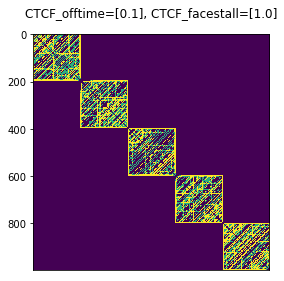

In [15]:
kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False) 
            
plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict['CTCF_offtime'],
                                                  paramdict['CTCF_facestall']),
          fontsize=12)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
                

In [16]:
# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':0, 'weak_CTCF':1}

site_types[:sites_per_replica//2] = typedict['strong_CTCF']
site_types[sites_per_replica//2:] = typedict['weak_CTCF']

In [17]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 0.5],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [10., 10.],
    'CTCF_offtime': [0.1, 0.1],
    'LEF_lifetime': [50, 50],
    'LEF_stalled_lifetime': [50, 50],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0, 0],
    'LEF_separation': 10,
    'sites_per_monomer': 10,
    'monomers_per_replica': 100,
    'number_of_replica': 10,
    'steps': 200,
    'velocity_multiplier': 1
}

In [18]:
CTCF_facestall = paramdict_CTCF['CTCF_facestall']

print(CTCF_facestall[typedict['strong_CTCF']], CTCF_facestall[typedict['weak_CTCF']])

1 0.5


In [19]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

In [20]:
trajectory_length = 1000 * paramdict_CTCF['sites_per_monomer']
hist = []

for _ in range(trajectory_length):
    translocator.step()
    hist.append(translocator.LEFs.copy())

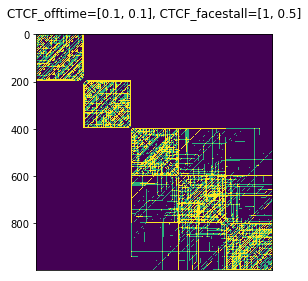

In [21]:
kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict_CTCF['sites_per_monomer'])), fignum=False) 
                    
plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict_CTCF['CTCF_offtime'],
                                                  paramdict_CTCF['CTCF_facestall']),
          fontsize=12)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
                

In [22]:
# Or, alternatively, a region with higher CTCF offtime
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.1, 1.]

In [23]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

In [24]:
trajectory_length = 1000 * paramdict_CTCF['sites_per_monomer']
hist = []

for _ in range(trajectory_length):
    translocator.step()
    hist.append(translocator.LEFs.copy())

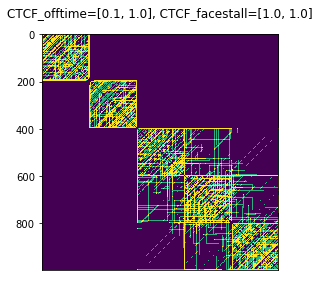

In [25]:
kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict_CTCF['sites_per_monomer'])), fignum=False) 
                    
plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict_CTCF['CTCF_offtime'],
                                                  paramdict_CTCF['CTCF_facestall']),
          fontsize=12)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
                